## Library Imports ##

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from typing import List
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Data Preprocessing ##

In [37]:
def preprocessing(visualize=False):
    lb=LabelBinarizer()

    # Load the training and test data
    train_df = pd.read_csv('archive/sign_mnist_train.csv')
    test_df = pd.read_csv('archive/sign_mnist_test.csv')

    # Separate features and labels
    x_train = train_df.drop('label', axis=1).values
    y_train = train_df['label'].values
    x_test = test_df.drop('label', axis=1).values
    y_test = test_df['label'].values
    
    unique_labels, label_counts = np.unique(y_train, return_counts=True)
    
    # Mean subtraction
    x_train = x_train - np.mean(x_train, axis=0)
    x_test = x_test - np.mean(x_test, axis=0)

    # Normalization 
    x_train = x_train / np.std(x_train)
    x_test = x_test / np.std(x_test)

    x_train1 =  x_train.reshape(-1,28,28,1)
    x_test1 = x_test.reshape(-1,28,28,1)

    x_train =  x_train.reshape(-1, 28*28).astype(np.float32)
    x_test = x_test.reshape(-1, 28*28).astype(np.float32)

    # Encoding the labels
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test)

    if (visualize==True):
    # Preview the dataset
        fig,axe=plt.subplots(2,2)
        fig.suptitle('Preview of dataset')
        axe[0,0].imshow(x_train1[0].reshape(28,28),cmap='gray')
        axe[0,0].set_title('label: 3  letter: C')
        axe[0,1].imshow(x_train1[1].reshape(28,28),cmap='gray')
        axe[0,1].set_title('label: 6  letter: F')
        axe[1,0].imshow(x_train1[2].reshape(28,28),cmap='gray')
        axe[1,0].set_title('label: 2  letter: B')
        axe[1,1].imshow(x_train1[4].reshape(28,28),cmap='gray')
        axe[1,1].set_title('label: 13  letter: M')

        # Confirm preprocessing
        print("Training data shape:", x_train.shape)
        print("Test data shape:", x_test.shape)
        print("Training labels shape:", y_train.shape)
        print("Test labels shape:", y_test.shape)

        # Print the maximum and minimum number of labels per class
        max_count = np.max(label_counts)
        min_count = np.min(label_counts)
        max_indices = np.where(label_counts == max_count)[0]
        min_indices = np.where(label_counts == min_count)[0]
        print(f"Maximum count - {unique_labels[max_indices]}: {max_count}")
        print(f"Minimum count - {unique_labels[min_indices]}: {min_count}")
    
    return x_train, y_train, x_test, y_test
    
x_train, y_train, x_test, y_test = preprocessing(visualize=False)

In [38]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
       
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError
    
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size) * np.sqrt(2. / input_size)  # He initialization
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return x @ self.w.T + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = gradient.T @ self.cur_input
        db = gradient.sum(axis=0)
        self.gradient = [dw, db]
        return gradient @ self.w

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        # Stabilization 
        shiftx = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(shiftx)
        probs = exps / np.sum(exps, axis=1, keepdims=True)
        self.cur_probs = probs
        return self.cur_probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target
    
class MLP:
    
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, x, y, optimizer, iterations=10, batch_size=24, lambda_reg=0.0, verbose=True):
        history = {
            "loss": [],
            "accuracy": []
        }
        
        for epoch in range(iterations):
            # Shuffle the data at the beginning of each epoch
            indices = np.arange(len(x))
            np.random.shuffle(indices)
            x = x[indices]
            y = y[indices]

            # Mini-batch gradient descent
            for start_idx in range(0, len(x), batch_size):
                # Create the mini-batch
                end_idx = min(start_idx + batch_size, len(x))
                x_batch = x[start_idx:end_idx]
                y_batch = y[start_idx:end_idx]

                # Forward pass
                output = self.forward(x_batch)

                # Loss computation 
                data_loss = compute_loss(output, y_batch)
                # Regularization loss
                reg_loss = lambda_reg * sum(np.sum(layer.w ** 2) for layer in self.layers if hasattr(layer, 'w'))
                loss = data_loss + reg_loss

                # Backward pass and optimization
                self.backward(y_batch)
                optimizer.step()

                # Compute and store the loss and accuracy
                history["loss"].append(loss)
                predictions = self.predict(x_batch)
                accuracy = self.evaluate_acc(y_batch, predictions)
                history["accuracy"].append(accuracy)
                
            # Verbose output for tracking progress
            if verbose:
                print(f'Epoch {epoch + 1}/{iterations} - Loss: {np.mean(history["loss"][-len(x)//batch_size:])}, '
                      f'Accuracy: {np.mean(history["accuracy"][-len(x)//batch_size:])}')
            

        return history
    
    def predict(self, x):
        predicts = self.forward(x)
        return np.argmax(predicts, axis=1)

    def evaluate_acc(self, y_true, y_pred):
        y_true_indices = np.argmax(y_true, axis=1)
        return np.mean(y_true_indices == y_pred)

class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError
    
# For experiment 3
class RegGradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, lambda_reg: float):
        super().__init__(net)
        self.lr = lr
        self.lambda_reg = lambda_reg

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * (g + self.lambda_reg * p)

# For experiment 5            
class AdamOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(net)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = []
        self.v = []
        self.t = 0

        # Initialize moment vectors for each parameter in the network
        for layer in net.layers:
            layer_m = []
            layer_v = []
            if hasattr(layer, 'parameters') and layer.parameters:
                for param in layer.parameters:
                    layer_m.append(np.zeros_like(param))
                    layer_v.append(np.zeros_like(param))
            self.m.append(layer_m)
            self.v.append(layer_v)
    
    def update(self, layer_index, gradients):
        self.t += 1
        layer_m = self.m[layer_index]
        layer_v = self.v[layer_index]
        
        # Update the parameters of the layer
        for i, (m, v, grad) in enumerate(zip(layer_m, layer_v, gradients)):
            if grad is not None:
                m[:] = self.beta1 * m + (1 - self.beta1) * grad
                v[:] = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

                # Bias correction
                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)

                # Update the parameter
                update_value = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.net.layers[layer_index].parameters[i] -= update_value

    # Update the parameters of the network
    def step(self):
        for i, layer in enumerate(self.net.layers):
            if hasattr(layer, 'parameters') and layer.parameters and layer.gradient:
                self.update(i, layer.gradient)
              
# For experiment 1-3
class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g

def compute_loss(output, y_batch):
    # Assuming y_batch is a one-hot encoded matrix of labels
    m = y_batch.shape[0]  # Number of examples
    # Clipping output to avoid division by zero
    output_clipped = np.clip(output, 1e-7, 1 - 1e-7)
    # Compute cross-entropy loss
    loss = -np.sum(y_batch * np.log(output_clipped)) / m
    return loss
    

    

## Building and Training ##

In [39]:
def build_and_train_mlp(x_train, y_train, x_test, y_test, layers, units, iterations):
    """
    This function builds an MLP model with the given architecture, trains it, and evaluates its performance.
    """
    input_size = x_train.shape[-1]  # Determine the input size from the training data
    output_size = y_train.shape[-1]  # Determine the output size from the training data
    
    mlp_layers = []

    # Add the layers to the MLP model based on the specified number of layers and units
    if layers == 0:
        mlp_layers.append(LinearLayer(input_size, output_size))
    elif layers == 1:
        mlp_layers.append(LinearLayer(input_size, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, output_size))
    elif layers == 2:
        mlp_layers.append(LinearLayer(input_size, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, output_size))
    mlp_layers.append(SoftmaxOutputLayer())
    
    # Instantiate the MLP model with the specified layers
    mlp = MLP(*mlp_layers)
    
    # Train the MLP model
    optimizer = GradientDescentOptimizer(mlp, lr=0.001)
    history = mlp.fit(x_train, y_train, optimizer, iterations=iterations)
    
    # Make predictions with the trained MLP model
    y_pred = mlp.predict(x_test)
    
    # Compute the accuracy
    accuracy = mlp.evaluate_acc(y_test, y_pred)  # Adjust based on y_test format

    return accuracy, history

## Experiments ##

### Experiment 1 ###

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8720981249314911, Accuracy: 0.8672405493057667
Epoch 2/10 - Loss: 0.31946164075533756, Accuracy: 0.975815850815851
Epoch 3/10 - Loss: 0.1976221889818113, Accuracy: 0.9937354312354314
Epoch 4/10 - Loss: 0.1404616516460951, Accuracy: 0.998324592074592
Epoch 5/10 - Loss: 0.10836460321693296, Accuracy: 0.9992715617715616
Epoch 6/10 - Loss: 0.08836981899683036, Accuracy: 0.9996722027972028
Epoch 7/10 - Loss: 0.07453172712826567, Accuracy: 0.9997450466200467
Epoch 8/10 - Loss: 0.06435913001553908, Accuracy: 0.9998178904428903
Epoch 9/10 - Loss: 0.05686452496569735, Accuracy: 0.9998178904428905
Epoch 10/10 - Loss: 0.050893996291126786, Accuracy: 0.9998907342657343


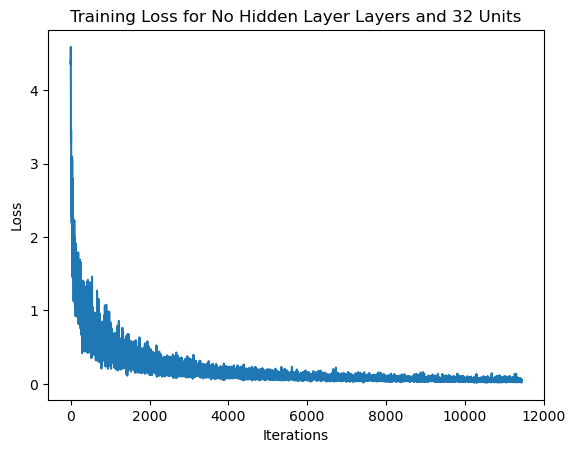

Units: 32, Test Accuracy: 0.6762409369771333

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8669583292528718, Accuracy: 0.8741227070031419
Epoch 2/10 - Loss: 0.3244560105279882, Accuracy: 0.9769085081585083
Epoch 3/10 - Loss: 0.20107844962757054, Accuracy: 0.991768648018648
Epoch 4/10 - Loss: 0.14226075973806404, Accuracy: 0.9978875291375291
Epoch 5/10 - Loss: 0.10959746104178415, Accuracy: 0.9993444055944056
Epoch 6/10 - Loss: 0.08895817160415981, Accuracy: 0.9996357808857809
Epoch 7/10 - Loss: 0.07498743239360545, Accuracy: 0.9997450466200467
Epoch 8/10 - Loss: 0.06488041024234051, Accuracy: 0.9997450466200466
Epoch 9/10 - Loss: 0.057290207839836106, Accuracy: 0.9998543123543124
Epoch 10/10 - Loss: 0.05123491502166007, Accuracy: 0.9998543123543123


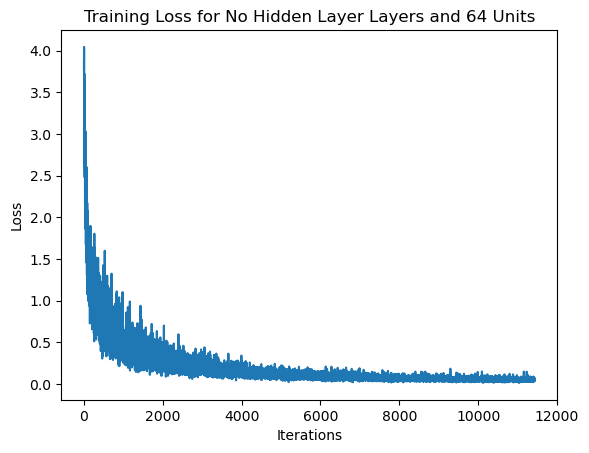

Units: 64, Test Accuracy: 0.6705242610150586

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8622265962927973, Accuracy: 0.8735067016317016
Epoch 2/10 - Loss: 0.32124042060556823, Accuracy: 0.975231516671734
Epoch 3/10 - Loss: 0.1992249408379868, Accuracy: 0.992642773892774
Epoch 4/10 - Loss: 0.14091177483676526, Accuracy: 0.9980332167832168
Epoch 5/10 - Loss: 0.10857330487603564, Accuracy: 0.999599358974359
Epoch 6/10 - Loss: 0.08842495468026203, Accuracy: 0.9996722027972028
Epoch 7/10 - Loss: 0.07456414905228324, Accuracy: 0.9997450466200466
Epoch 8/10 - Loss: 0.06452282227330543, Accuracy: 0.9998543123543124
Epoch 9/10 - Loss: 0.05702069187594819, Accuracy: 0.9998907342657343
Epoch 10/10 - Loss: 0.05091710346253514, Accuracy: 0.9999635780885783


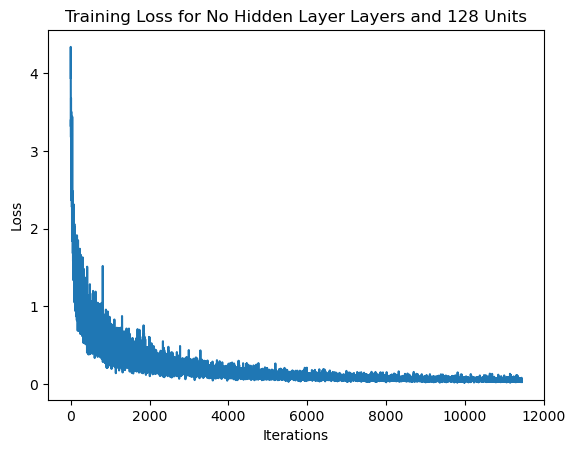

Units: 128, Test Accuracy: 0.6717791411042945

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8820104457935392, Accuracy: 0.8666197932502281
Epoch 2/10 - Loss: 0.32183047167484324, Accuracy: 0.9770541958041958
Epoch 3/10 - Loss: 0.19978490826802484, Accuracy: 0.9928977272727273
Epoch 4/10 - Loss: 0.1415105241063473, Accuracy: 0.998433857808858
Epoch 5/10 - Loss: 0.1089796075646669, Accuracy: 0.9993444055944056
Epoch 6/10 - Loss: 0.08879336268428935, Accuracy: 0.9997086247086248
Epoch 7/10 - Loss: 0.07485858175713597, Accuracy: 0.9996722027972028
Epoch 8/10 - Loss: 0.06484135298450691, Accuracy: 0.9998543123543124
Epoch 9/10 - Loss: 0.05718106573691576, Accuracy: 0.9997814685314685
Epoch 10/10 - Loss: 0.05121597465177816, Accuracy: 0.9998178904428903


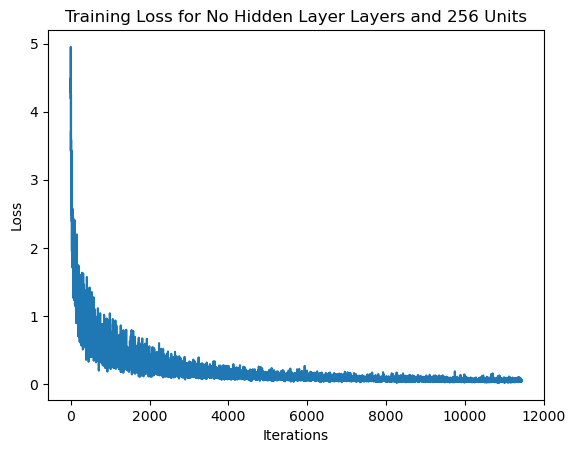

Units: 256, Test Accuracy: 0.6840490797546013

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.9001441431011951, Accuracy: 0.8568618881118881
Epoch 2/10 - Loss: 0.1699133565888932, Accuracy: 0.9951194638694639
Epoch 3/10 - Loss: 0.06757069039878841, Accuracy: 1.0
Epoch 4/10 - Loss: 0.037793459499631595, Accuracy: 1.0
Epoch 5/10 - Loss: 0.025287366939937182, Accuracy: 1.0
Epoch 6/10 - Loss: 0.018706108065391695, Accuracy: 1.0
Epoch 7/10 - Loss: 0.01469506049151107, Accuracy: 1.0
Epoch 8/10 - Loss: 0.012024963784713658, Accuracy: 1.0
Epoch 9/10 - Loss: 0.010139737315719698, Accuracy: 1.0
Epoch 10/10 - Loss: 0.00872679950701194, Accuracy: 1.0


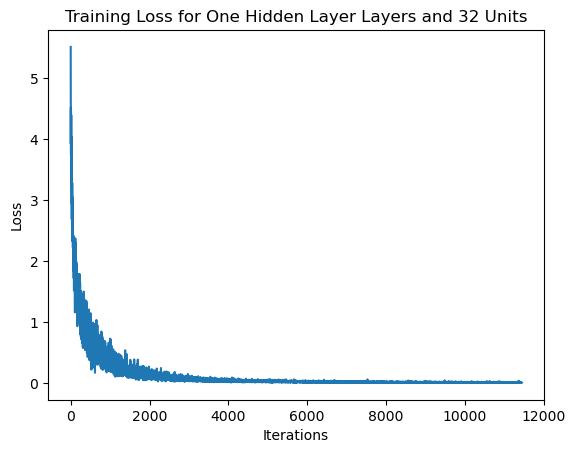

Units: 32, Test Accuracy: 0.706776352481874

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.7259057934465567, Accuracy: 0.9069784382284382
Epoch 2/10 - Loss: 0.1004274724434129, Accuracy: 0.9994536713286714
Epoch 3/10 - Loss: 0.04123751031155234, Accuracy: 1.0
Epoch 4/10 - Loss: 0.02446525745579512, Accuracy: 1.0
Epoch 5/10 - Loss: 0.017115785314209573, Accuracy: 1.0
Epoch 6/10 - Loss: 0.012991230008295208, Accuracy: 1.0
Epoch 7/10 - Loss: 0.010386999966119522, Accuracy: 1.0
Epoch 8/10 - Loss: 0.00862139144361363, Accuracy: 1.0
Epoch 9/10 - Loss: 0.007328297197466241, Accuracy: 1.0
Epoch 10/10 - Loss: 0.006366318007963329, Accuracy: 1.0


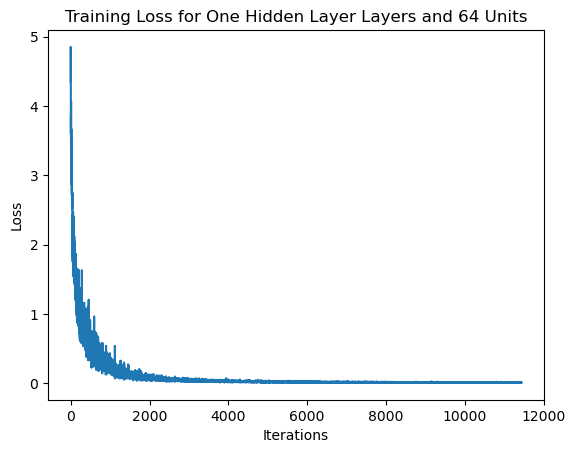

Units: 64, Test Accuracy: 0.792526491912995

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.6246120289623818, Accuracy: 0.9303248834498833
Epoch 2/10 - Loss: 0.0843650508285932, Accuracy: 0.9999271561771562
Epoch 3/10 - Loss: 0.03581092705988012, Accuracy: 1.0
Epoch 4/10 - Loss: 0.021703027425029258, Accuracy: 1.0
Epoch 5/10 - Loss: 0.015286317140699954, Accuracy: 1.0
Epoch 6/10 - Loss: 0.011671394365457706, Accuracy: 1.0
Epoch 7/10 - Loss: 0.009367546014145597, Accuracy: 1.0
Epoch 8/10 - Loss: 0.007807881941861855, Accuracy: 1.0
Epoch 9/10 - Loss: 0.006666415570404749, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0058015395940927035, Accuracy: 1.0


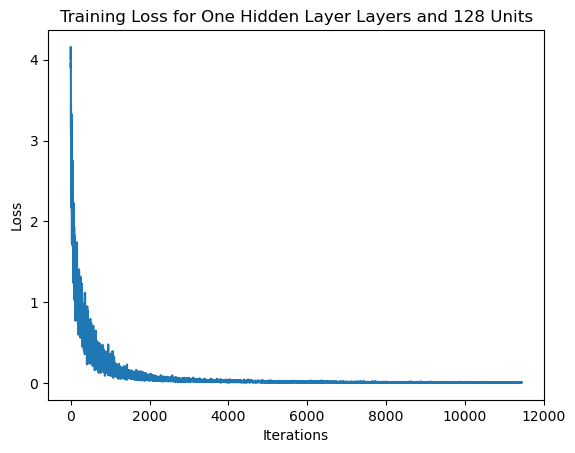

Units: 128, Test Accuracy: 0.7700780814277747

Testing architecture: One Hidden Layer
Epoch 1/10 - Loss: 0.5756062492316518, Accuracy: 0.9470061188811189
Epoch 2/10 - Loss: 0.07127597744423024, Accuracy: 0.9999635780885783
Epoch 3/10 - Loss: 0.031431363139872326, Accuracy: 1.0
Epoch 4/10 - Loss: 0.01927462067406835, Accuracy: 1.0
Epoch 5/10 - Loss: 0.013692844206535996, Accuracy: 1.0
Epoch 6/10 - Loss: 0.010551841208638864, Accuracy: 1.0
Epoch 7/10 - Loss: 0.008521508200182552, Accuracy: 1.0
Epoch 8/10 - Loss: 0.007111400057738091, Accuracy: 1.0
Epoch 9/10 - Loss: 0.006092849254136352, Accuracy: 1.0
Epoch 10/10 - Loss: 0.005307785883833245, Accuracy: 1.0


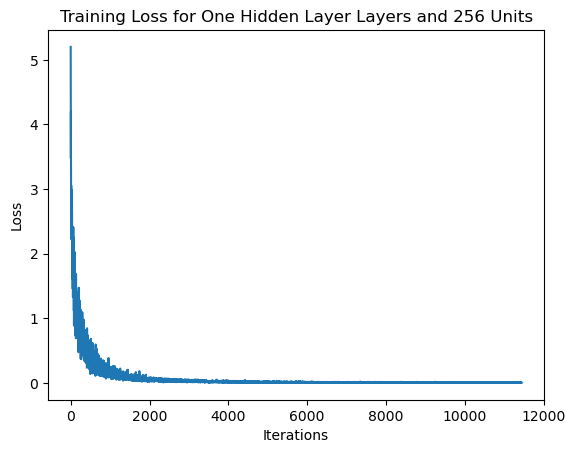

Units: 256, Test Accuracy: 0.7968488566648075

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.9466795144853888, Accuracy: 0.8435663068815242
Epoch 2/10 - Loss: 0.1023928123601608, Accuracy: 0.9981789044289044
Epoch 3/10 - Loss: 0.027869955932037834, Accuracy: 1.0
Epoch 4/10 - Loss: 0.01423622693469053, Accuracy: 1.0
Epoch 5/10 - Loss: 0.009142257725952275, Accuracy: 1.0
Epoch 6/10 - Loss: 0.006592063159323558, Accuracy: 1.0
Epoch 7/10 - Loss: 0.005110553543902456, Accuracy: 1.0
Epoch 8/10 - Loss: 0.004145732639670911, Accuracy: 1.0
Epoch 9/10 - Loss: 0.003444282945336882, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0029784280754410254, Accuracy: 1.0


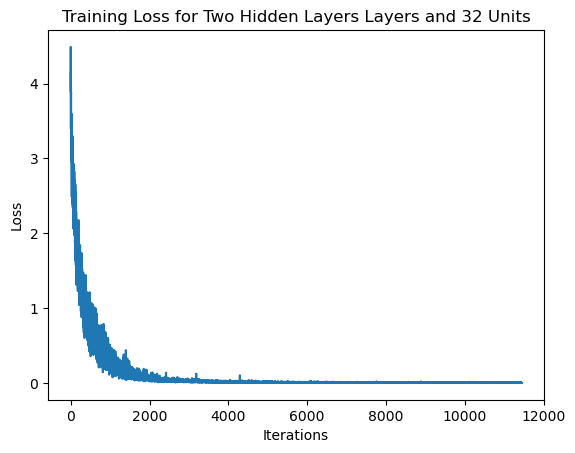

Units: 32, Test Accuracy: 0.7112381483547128

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.6498328662487607, Accuracy: 0.9231861888111889
Epoch 2/10 - Loss: 0.04972883329989936, Accuracy: 1.0
Epoch 3/10 - Loss: 0.017360945321111265, Accuracy: 1.0
Epoch 4/10 - Loss: 0.009879292878448282, Accuracy: 1.0
Epoch 5/10 - Loss: 0.0067157800732089885, Accuracy: 1.0
Epoch 6/10 - Loss: 0.00500071796456193, Accuracy: 1.0
Epoch 7/10 - Loss: 0.003949747821955314, Accuracy: 1.0
Epoch 8/10 - Loss: 0.003244509677645673, Accuracy: 1.0
Epoch 9/10 - Loss: 0.0027444600727604177, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0023674418697740627, Accuracy: 1.0


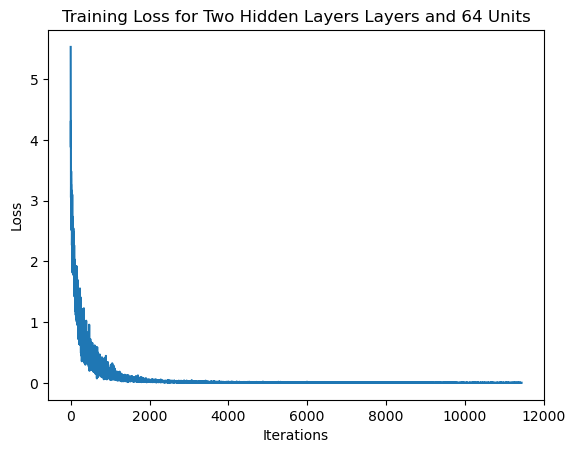

Units: 64, Test Accuracy: 0.7511154489682097

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.552733303840203, Accuracy: 0.9416885198135196
Epoch 2/10 - Loss: 0.03466989963025435, Accuracy: 1.0
Epoch 3/10 - Loss: 0.013437561403486883, Accuracy: 1.0
Epoch 4/10 - Loss: 0.007984067981155715, Accuracy: 1.0
Epoch 5/10 - Loss: 0.005556153850847254, Accuracy: 1.0
Epoch 6/10 - Loss: 0.004213871422661306, Accuracy: 1.0
Epoch 7/10 - Loss: 0.003369438815063363, Accuracy: 1.0
Epoch 8/10 - Loss: 0.0027958768841067757, Accuracy: 1.0
Epoch 9/10 - Loss: 0.002376893441336794, Accuracy: 1.0
Epoch 10/10 - Loss: 0.002062187915447899, Accuracy: 1.0


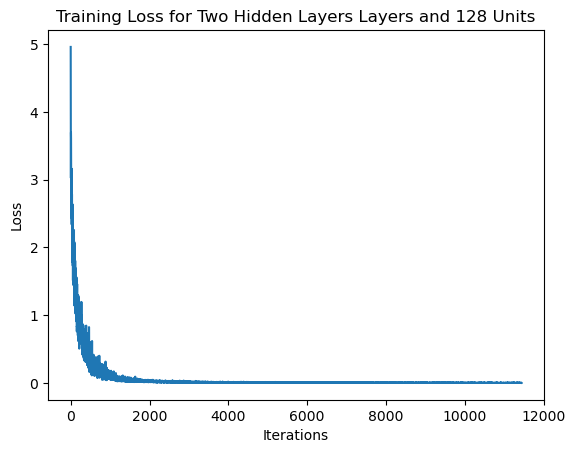

Units: 128, Test Accuracy: 0.7760736196319018

Testing architecture: Two Hidden Layers
Epoch 1/10 - Loss: 0.463403621826546, Accuracy: 0.9643065268065266
Epoch 2/10 - Loss: 0.027285294869043797, Accuracy: 1.0
Epoch 3/10 - Loss: 0.011631047949905252, Accuracy: 1.0
Epoch 4/10 - Loss: 0.007153680427361356, Accuracy: 1.0
Epoch 5/10 - Loss: 0.00507974403116187, Accuracy: 1.0
Epoch 6/10 - Loss: 0.0038998767406034597, Accuracy: 1.0
Epoch 7/10 - Loss: 0.0031397549166688543, Accuracy: 1.0
Epoch 8/10 - Loss: 0.002616720905877216, Accuracy: 1.0
Epoch 9/10 - Loss: 0.002234775099045588, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0019457121307500961, Accuracy: 1.0


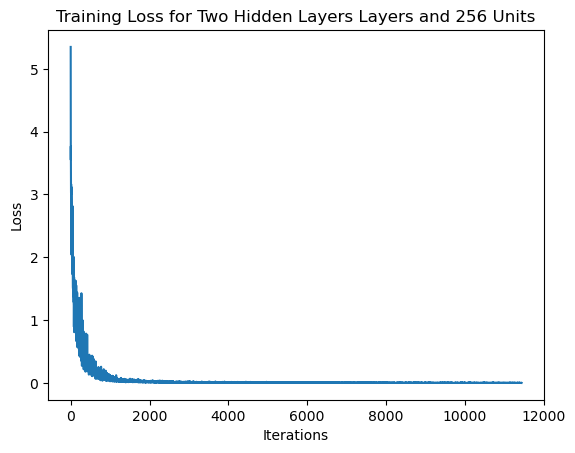

Units: 256, Test Accuracy: 0.7810931399888456

Max Accuracy: 0.7968488566648075, for Units: 256 and Layers: One Hidden Layer


In [40]:
def experiment_1(hidden_units, hidden_layers, iterations, plot_show=False):
   
    # Results dictionary to store the accuracy for each architecture and unit configuration
    results = {}
    max_accuracy = 0
    max_accuracy_units = []
    max_accuracy_layers = []
    # Run experiments
    for layers in hidden_layers:
        arch_results = []
        for units in hidden_units:
            # If the architecture has hidden layers (is not empty)
            
            if layers == 0:
                num_layers = "No Hidden Layer"
            elif layers == 1:
                num_layers = "One Hidden Layer"
            elif layers == 2:
                num_layers = "Two Hidden Layers"

            # Print the architecture being tested for clarity
            print(f"Testing architecture: {num_layers}")
            
            # Train the model and evaluate accuracy
            accuracy, history = build_and_train_mlp(
                x_train, y_train, 
                x_test, y_test,
                layers, units,
                iterations
            )
            
            # Store and print the accuracy for the current configuration
            arch_results.append((units, accuracy))
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                max_accuracy_units = units
                max_accuracy_layers = num_layers

            if plot_show:
                # Plot the training loss
                plt.plot(history['loss'])
                plt.title('Training Loss for ' + num_layers + ' Layers and ' + str(units) + ' Units')
                plt.xlabel('Iterations')
                plt.ylabel('Loss')
                plt.show()
            
            print(f"Units: {units}, Test Accuracy: {accuracy}\n")
            
        # Store the results for the current architecture
        results[str(layers)] = arch_results
    print(f"Max Accuracy: {max_accuracy}, for Units: {max_accuracy_units} and Layers: {max_accuracy_layers}")

    return results
# Experiment parameters
hidden_units = [32, 64, 128, 256]
hidden_layers = [0,1,2]
    
results = experiment_1(hidden_units, hidden_layers, iterations=10, plot_show=True)

#### Graph accuracy given the number of hidden units for each layer configuration

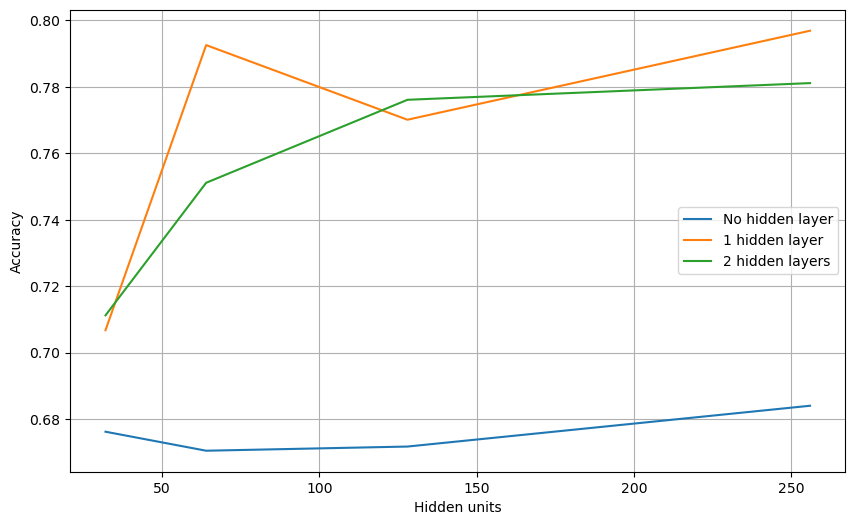

In [41]:
plt.figure(figsize=(10, 6))
labels = ["No hidden layer", "1 hidden layer", "2 hidden layers"]
for idx, (key, value) in enumerate(results.items()):
    x = [item[0] for item in value]
    y = [item[1] for item in value]
    plt.plot(x, y, label=labels[idx])

plt.xlabel('Hidden units')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 2 ###

In [42]:
class SigmoidLayer(NeuralNetLayer):
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, dout):
        return dout * (self.output * (1 - self.output))

class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, x):
        self.x = x
        return np.where(x > 0, x, self.alpha * x)
    
    def backward(self, dout):
        dx = np.ones_like(self.x)
        dx[self.x < 0] = self.alpha
        return dout * dx

def experiment_2(x_train, y_train, x_test, y_test, activation_layer, hidden_units=[64, 64]):
    # Construct the model architecture
    layers = [LinearLayer(x_train.shape[-1], hidden_units[0]), activation_layer()]
    for units in hidden_units[1:]:
        layers.append(LinearLayer(units, units))
        layers.append(activation_layer())
    layers.append(LinearLayer(hidden_units[-1], y_train.shape[-1]))  
    layers.append(SoftmaxOutputLayer())
    

    # Create and train the MLP model
    mlp = MLP(*layers)
    optimizer = GradientDescentOptimizer(mlp, lr=0.001)
    mlp.fit(x_train, y_train, optimizer, iterations=10)
    
    # Evaluate the model
    y_pred = mlp.predict(x_test)
    accuracy = mlp.evaluate_acc(y_test, y_pred)
    return accuracy

# Activation functions to test
activations = {
    "Sigmoid": SigmoidLayer,
    "Leaky ReLU": LeakyReLULayer,
    "ReLU": ReLULayer  
}

# Training and evaluating models with different activations
results = {}
for name, activation_layer in activations.items():
    accuracy = experiment_2(
        x_train, y_train, 
        x_test, y_test, 
        activation_layer, hidden_units=[64, 64] # 2 hidden layers with 64 units each
    )
    results[name] = accuracy
    print(f"{name} activation: Test Accuracy = {accuracy}")

Epoch 1/10 - Loss: 2.8854796548347323, Accuracy: 0.2431669327049762
Epoch 2/10 - Loss: 2.1711176981523876, Accuracy: 0.469532279314888
Epoch 3/10 - Loss: 1.6536542316358056, Accuracy: 0.632384146650451
Epoch 4/10 - Loss: 1.2867705101058438, Accuracy: 0.7229701910408433
Epoch 5/10 - Loss: 1.020507807259453, Accuracy: 0.7887465795074491
Epoch 6/10 - Loss: 0.8245283278756854, Accuracy: 0.8428727070031419
Epoch 7/10 - Loss: 0.6720192619086909, Accuracy: 0.8817000481402655
Epoch 8/10 - Loss: 0.549732701880023, Accuracy: 0.9176073021181715
Epoch 9/10 - Loss: 0.4498392917551046, Accuracy: 0.943691724941725
Epoch 10/10 - Loss: 0.3685651221229025, Accuracy: 0.9607371794871796
Sigmoid activation: Test Accuracy = 0.7200223089793641
Epoch 1/10 - Loss: 0.6299458575111353, Accuracy: 0.9290865384615384
Epoch 2/10 - Loss: 0.05207050396077766, Accuracy: 0.999963578088578
Epoch 3/10 - Loss: 0.018378729788064485, Accuracy: 1.0
Epoch 4/10 - Loss: 0.010537519830456157, Accuracy: 1.0
Epoch 5/10 - Loss: 0.00

#### Bar plot showing accuracy of MLP using RELU, Leaky RELU, and Sigmoid activation function

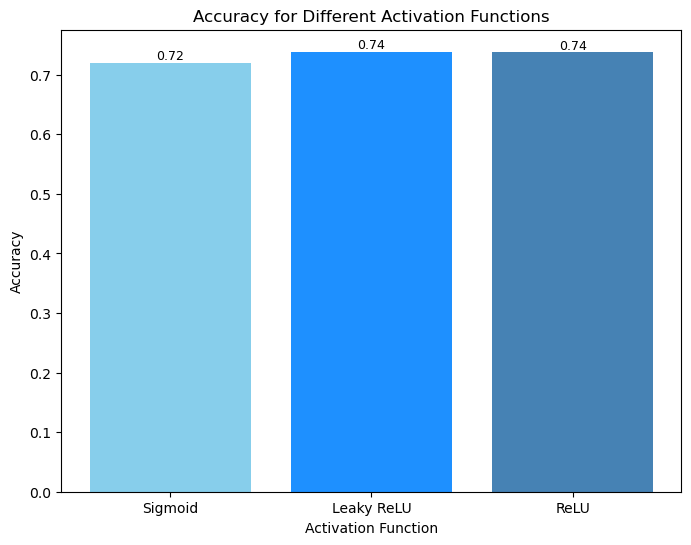

In [43]:
# Define shades of blue
colors = ['skyblue', 'dodgerblue', 'steelblue']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(results.keys(), results.values(), color=colors)
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Activation Functions')

# Add value at the top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '{:.2f}'.format(height),
             ha='center', va='bottom', fontsize=9)

plt.show()

### Experiment 3 ###

In [49]:
lambdas = [0, 0.001, 0.01, 0.1, 1]  # Different values of lambda for L2 regularization
batch_size = 24 # Mini-batch size
units = 32 # Number of units in the hidden layers
accuracies = []

for lambda_reg in lambdas:
    print(f"Training with lambda = {lambda_reg} and units = {units}")
    mlp = MLP(
        LinearLayer(x_train.shape[-1], units),
        ReLULayer(),
        LinearLayer(units, units),
        ReLULayer(),
        LinearLayer(units, y_train.shape[-1]),
        SoftmaxOutputLayer()
    )
    optimizer = RegGradientDescentOptimizer(mlp, lr=0.001, lambda_reg=lambda_reg)
    history = mlp.fit(x_train, y_train, optimizer, iterations=10, batch_size=batch_size, lambda_reg=lambda_reg)
    y_pred = mlp.predict(x_test)
    accuracy = mlp.evaluate_acc(y_test, y_pred)
    print(f"Accuracy with L2 regularization and lambda={lambda_reg}: {accuracy}")
    accuracies.append(accuracy)

Training with lambda = 0 and units = 32
Epoch 1/10 - Loss: 0.9184545089636126, Accuracy: 0.8571532634032634
Epoch 2/10 - Loss: 0.10797131908428301, Accuracy: 0.9974140442890443
Epoch 3/10 - Loss: 0.031849788368606434, Accuracy: 1.0
Epoch 4/10 - Loss: 0.01622661301626987, Accuracy: 1.0
Epoch 5/10 - Loss: 0.010446274488721612, Accuracy: 1.0
Epoch 6/10 - Loss: 0.007504754417529962, Accuracy: 1.0
Epoch 7/10 - Loss: 0.005782290247545107, Accuracy: 1.0
Epoch 8/10 - Loss: 0.004630158986204561, Accuracy: 1.0
Epoch 9/10 - Loss: 0.003878384163221083, Accuracy: 1.0
Epoch 10/10 - Loss: 0.003300223421368125, Accuracy: 1.0
Accuracy with L2 regularization and lambda=0: 0.7236475181260458
Training with lambda = 0.001 and units = 32
Epoch 1/10 - Loss: 1.05724371206327, Accuracy: 0.8742715617715617
Epoch 2/10 - Loss: 0.3417842834443471, Accuracy: 0.9992351398601399
Epoch 3/10 - Loss: 0.2979786948622982, Accuracy: 1.0
Epoch 4/10 - Loss: 0.29649924565210756, Accuracy: 1.0
Epoch 5/10 - Loss: 0.299083179793

#### Line plot showing how the accuracy of a machine learning model changes with different levels of L2 regularization

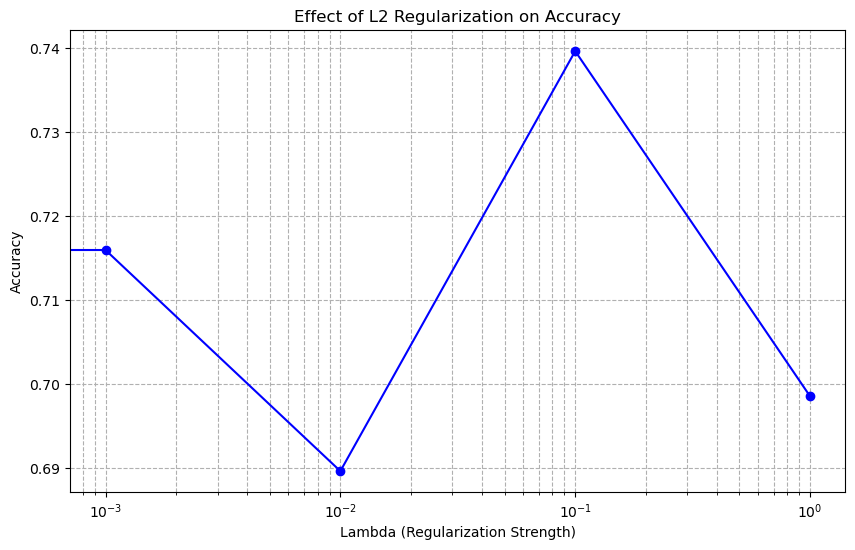

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(lambdas, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Effect of L2 Regularization on Accuracy')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

### Experiment 4 ###

In [45]:
# Load the data
train_df = pd.read_csv('archive/sign_mnist_train.csv')
test_df = pd.read_csv('archive/sign_mnist_test.csv')

# Extract labels and features
y_train = train_df.pop('label').values
x_train = train_df.values
y_test = test_df.pop('label').values
x_test = test_df.values

# Normalize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train).astype(np.float32)
x_test = scaler.transform(x_test).astype(np.float32)

# Reshape the features
x_train = x_train.reshape((-1, 1, 28, 28))
x_test = x_test.reshape((-1, 1, 28, 28))

# One-hot encode labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the ConvNet model
class ConvNet(nn.Module):
    def __init__(self, hidden_units):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, hidden_units)  # 3x3 is the spatial dimension of the output volume
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, 26)  # 26 classes
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Training and evaluation function
def train_and_evaluate_model(hidden_units):
    model = ConvNet(hidden_units)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    for epoch in range(10):  # 10 iterations
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
            
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()

    test_acc = correct / total
    return test_acc

# Running the experiments
hidden_units_options = [32, 64, 128, 256]
results = {}
for hidden_units in hidden_units_options:
    test_acc = train_and_evaluate_model(hidden_units)
    results[hidden_units] = test_acc
    print(f"Training with {hidden_units} hidden units, Test Accuracy: {test_acc:.4f}")

#Find the best performance
best_units = max(results, key=results.get)
print(f"Best performance with {best_units} hidden units: {results[best_units]:.4f}")
convnet_accuracy = results[best_units] # for experiment 5

Training with 32 hidden units, Test Accuracy: 0.9569
Training with 64 hidden units, Test Accuracy: 0.9626
Training with 128 hidden units, Test Accuracy: 0.9810
Training with 256 hidden units, Test Accuracy: 0.9654
Best performance with 128 hidden units: 0.9810


### Line chart comparing the performance of a neural network with different numbers of hidden units

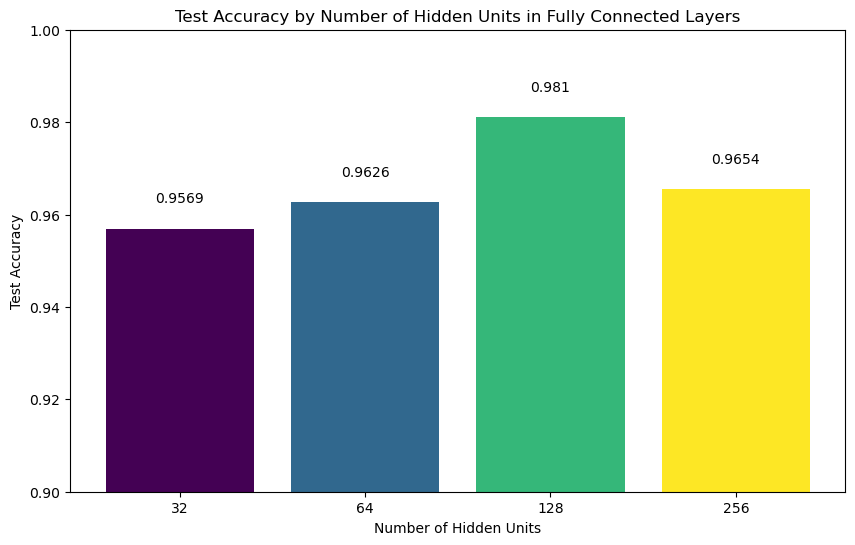

In [63]:
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(results)), results.values(), color=colors, align='center')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom')

plt.xticks(range(len(results)), [str(k) for k in results.keys()])
plt.xlabel('Number of Hidden Units')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy by Number of Hidden Units in Fully Connected Layers')
plt.ylim([0.9, 1])
plt.show()

### Experiment 5 ### 

In [55]:
x_train, y_train, x_test, y_test = preprocessing()

# Define the MLP architecture 
units = 256 # If you want to skip running the previous cell you can use 128 or 256
input_size = x_train.shape[-1]  # Determine the input size from the training data
output_size = y_train.shape[-1]  # Determine the output size from the training data
mlp = MLP(
    LinearLayer(input_size, units),  
    ReLULayer(),            
    LinearLayer(units, units),  
    ReLULayer(),            
    LinearLayer(units, units),  
    ReLULayer(),            
    LinearLayer(units, output_size),   
    SoftmaxOutputLayer()    
)

# Initialize the Optimizer 
adam_optimizer = AdamOptimizer(mlp, lr=0.001)

# Train the MLP model
mlp.fit(x_train, y_train, optimizer=adam_optimizer, iterations=10, verbose=True)

# Evaluate the model's performance on the test set
y_pred = mlp.predict(x_test)
accuracy = mlp.evaluate_acc(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")


Epoch 1/10 - Loss: 0.33519793459659564, Accuracy: 0.9418706293706294
Epoch 2/10 - Loss: 0.0005268330044253267, Accuracy: 1.0
Epoch 3/10 - Loss: 0.00018031653466948558, Accuracy: 1.0
Epoch 4/10 - Loss: 8.50796480342955e-05, Accuracy: 1.0
Epoch 5/10 - Loss: 4.303374520106662e-05, Accuracy: 1.0
Epoch 6/10 - Loss: 2.229617146404531e-05, Accuracy: 1.0
Epoch 7/10 - Loss: 1.197703043077773e-05, Accuracy: 1.0
Epoch 8/10 - Loss: 6.310719478296975e-06, Accuracy: 1.0
Epoch 9/10 - Loss: 3.368836781142255e-06, Accuracy: 1.0
Epoch 10/10 - Loss: 1.7501746432400828e-06, Accuracy: 1.0
Test accuracy: 0.8497


0.8496932515337423


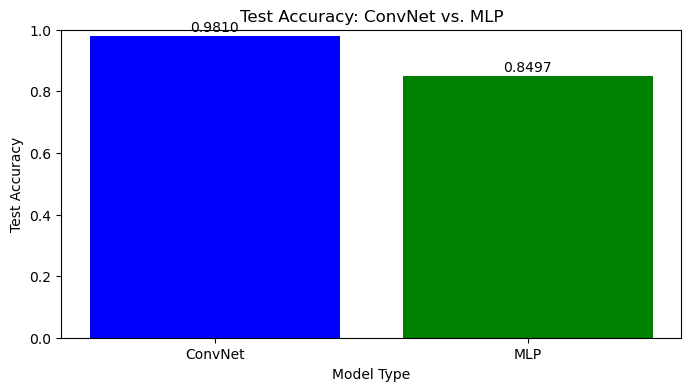

In [61]:
accuracies = [convnet_accuracy, accuracy]
labels = ['ConvNet', 'MLP']

plt.figure(figsize=(8, 4))
plt.bar(labels, accuracies, color=['blue', 'green'])

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom')

plt.xlabel('Model Type')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy: ConvNet vs. MLP')

plt.ylim([0, 1])
plt.show()
